# View the simulated spectrum of CTIO Data in November 2016
==================================================================================================

- author : Sylvie Dagoret-Campagne
- date   : December 16th 2016



In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os

In [15]:
import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [16]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal

In [17]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.0.0


In [18]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [19]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [20]:
from IPython.display import Image, display

In [21]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [22]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [23]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

In [24]:

object_name='HD14943'

In [25]:
#ensure_dir(outputdir)

In [26]:
simspecdir='/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2016/simu_spectra/fits/HD14943_m10'

## Read the simulated spectra

In [27]:
inputsim_filelist=os.listdir(simspecdir) 

In [28]:
if '.DS_Store' in inputsim_filelist:
    inputsim_filelist.remove('.DS_Store')
inputsim_filelist=np.array(inputsim_filelist)

In [29]:
print inputsim_filelist[0:5]

['RT_CT_pp_us_sa_rt_HD14943_Nev100_y2016_m10_aver_spectra.fits'
 'RT_CT_pp_us_sa_rt_HD14943_Nev101_y2016_m10_aver_spectra.fits'
 'RT_CT_pp_us_sa_rt_HD14943_Nev102_y2016_m10_aver_spectra.fits'
 'RT_CT_pp_us_sa_rt_HD14943_Nev103_y2016_m10_aver_spectra.fits'
 'RT_CT_pp_us_sa_rt_HD14943_Nev104_y2016_m10_aver_spectra.fits']


In [30]:
print re.findall('^RT_CT_pp_us_sa_rt_HD14943_Nev(.*)_y2016_m10_aver_spectra.fits',inputsim_filelist[0])

['100']


In [31]:
indexes_simfiles= [] # global list
filelist_simfitspec= []  # global list

In [32]:
#%%cython

import numpy as np
import re

def MakeSimFileList(inputdir,input_filelist):
    """
    MakeFileList : Make The List of files to open
    =============
    """
    
#    import numpy as np
#    import re
    indexes_files= [] # global list
    filelist_fitsimages= []  # global list
    index=0

    
    for file in input_filelist: # loop on directories, one per image       
            filename=inputdir+'/'+file
            if re.search('.*fits$',filename):  #example of filename filter
                index=index+1
                filelist_fitsimages.append(filename)
                str_num=re.findall('^RT_CT_pp_us_sa_rt_HD14943_Nev(.*)_y2016_m10_aver_spectra.fits',file)
                number=int(str_num[0])
                indexes_files.append(number)
    return indexes_files, filelist_fitsimages

In [33]:
indexes_simfiles, filelist_simfitspec=MakeSimFileList(simspecdir,inputsim_filelist)   # filter to take only fits file

In [34]:
# transform into numpy arrays
indexes_simfiles=np.array(indexes_simfiles)
filelist_simfitspec=np.array(filelist_simfitspec)

In [35]:
print indexes_simfiles

[100 101 102 103 104 105 106 107 108 109  10 110 111 112 113 114 115 116
 117  11  12  13  14  15  16  17  18  19   1  20  21  22  23  24  25  26
  27  28  29   2  30  31  32  33  34  35  36  37  38  39   3  40  41  42
  43  44  45  46  47  48  49   4  50  51  52  53  54  55  56  57  58  59
   5  60  61  62  63  64  65  66  67  68  69   6  70  71  72  73  74  75
  76  77  78  79   7  80  81  82  83  84  85  86  87  88  89   8  90  91
  92  93  94  95  96  97  98  99   9]


In [36]:
sorted_simindexes=np.argsort(indexes_simfiles) # sort the file indexes

In [37]:
sorted_simindexes

array([ 28,  39,  50,  61,  72,  83,  94, 105, 116,  10,  19,  20,  21,
        22,  23,  24,  25,  26,  27,  29,  30,  31,  32,  33,  34,  35,
        36,  37,  38,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115,   0,   1,   2,   3,   4,
         5,   6,   7,   8,   9,  11,  12,  13,  14,  15,  16,  17,  18])

In [38]:
sorted_simnumbers=indexes_simfiles[sorted_simindexes] # check the ordering with argsort is correct

In [39]:
print sorted_simnumbers # check

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117]


In [40]:
sorted_simfiles=filelist_simfitspec[sorted_simindexes] # now sort the filenames

In [41]:
print sorted_simfiles[0:5] # check

[ '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2016/simu_spectra/fits/HD14943_m10/RT_CT_pp_us_sa_rt_HD14943_Nev1_y2016_m10_aver_spectra.fits'
 '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2016/simu_spectra/fits/HD14943_m10/RT_CT_pp_us_sa_rt_HD14943_Nev2_y2016_m10_aver_spectra.fits'
 '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2016/simu_spectra/fits/HD14943_m10/RT_CT_pp_us_sa_rt_HD14943_Nev3_y2016_m10_aver_spectra.fits'
 '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2016/simu_spectra/fits/HD14943_m10/RT_CT_pp_us_sa_rt_HD14943_Nev4_y2016_m10_aver_spectra.fits'
 '/Users/dagoret-campagnesylvie/MacOsX/LSST/MyWork/GitHub/CTIOAna2016/simu_spectra/fits/HD14943_m10/RT_CT_pp_us_sa_rt_HD14943_Nev5_y2016_m10_aver_spectra.fits']


In [42]:
hdu_list=fits.open(sorted_simfiles[49])
header=hdu_list[0].header

In [43]:
print header

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  OBJ_NAME= 'HD14943 '                                                            AIRMASS =    1.156999945640564                                                  UNITS   = 'wavelength in nm'                                                    DATE    = '2016-11-25T00:51:28.239'                                             EXPOSURE=                 40.0                                                  FILENAME= '2016_11_25T00_52_10'                                                 COMMENT Prediction of observable SPECTRA                                        END                                                                                                                     

In [44]:
 table_data=hdu_list[1].data

In [45]:
print table_data.columns

ColDefs(
    name = 'WAVELENGTH'; format = 'E'
    name = 'SEDcalspec'; format = 'E'
    name = 'Atmosphere'; format = 'E'
    name = 'QE'; format = 'E'
    name = 'SEDxQExATM'; format = 'E'
)


In [46]:
simwavelength = table_data.field('WAVELENGTH')
simsed        = table_data.field('SEDcalspec')
simatm        = table_data.field('Atmosphere')
simqe         = table_data.field('QE')
simspectra    = table_data.field('SEDxQExATM')

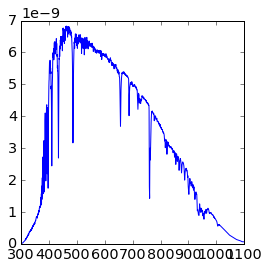

In [47]:
plt.plot(simwavelength,simspectra )

In [48]:
#%%cython

#import numpy as np
#from astropy.io import fits
def BuildSimSpec(sorted_filenames,sorted_numbers,object_name):
    """
    BuildSimSpec
    ===============
    """

    all_dates = []
    all_airmass = []
    
    all_simwavelength = []
    all_simspectra = []
    all_simatmosphere = []
    all_simqe = []
    all_simsed = []
    
    all_titles = []
    all_header = []
    all_expo = []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        print idx
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        header=hdu_list[0].header
                
        #print header
        date_obs = header['DATE']
        airmass = header['AIRMASS']
        expo = header['EXPOSURE']
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        
        # now reads the spectra
        
        table_data=hdu_list[1].data
        
        simwavelength = table_data.field('WAVELENGTH')
        simsed        = table_data.field('SEDcalspec')
        simatm        = table_data.field('Atmosphere')
        simqe         = table_data.field('QE')
        simspectra    = table_data.field('SEDxQExATM')
        
        
        all_simwavelength.append(simwavelength)
        all_simspectra.append(simspectra)
        all_simatmosphere.append(simatm)
        all_simqe.append(simqe)
        all_simsed.append(simsed)
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
            
        all_titles.append(title)
        all_header.append(header)
        all_expo.append(expo)
        hdu_list.close()
        
    return all_dates,all_airmass,all_titles,all_header,all_expo,all_simwavelength,all_simspectra,all_simatmosphere,all_simqe,all_simsed

In [49]:
all_simdates,all_simairmass,all_simtitles,all_simheader,all_simexpo,all_simwavelength,all_simspectra,all_simatmosphere,all_simqe,all_simsed=BuildSimSpec(sorted_simfiles,sorted_simnumbers,object_name)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116


In [58]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
    
def ShowSpectra(all_wavelength,all_simspec,all_simtitles,object_name):
    """
    ShowSpectra: Show the raw images without background subtraction
    ==============
    """
    NBIMAGES=len(all_simspec)
    MAXIMGROW=int(NBIMAGES/5)+1
    thex0 = []
    f, axarr = plt.subplots(MAXIMGROW,5,figsize=(25,60))
    f.tight_layout()
    #plt.subplot_tool() 
    for index in np.arange(0,NBIMAGES):
        ix=index%5
        iy=index/5
        wavelength=all_wavelength[index]
        spectrum=all_simspec[index]
        axarr[iy,ix].plot(wavelength,spectrum,'r-',lw=2)
        axarr[iy,ix].set_title(all_simtitles[index])
        #axarr[iy,ix].set_ylim(0.,200.)
        axarr[iy,ix].grid(True)
      
    #title='spectra'
    #plt.suptitle(title,size=16)
   

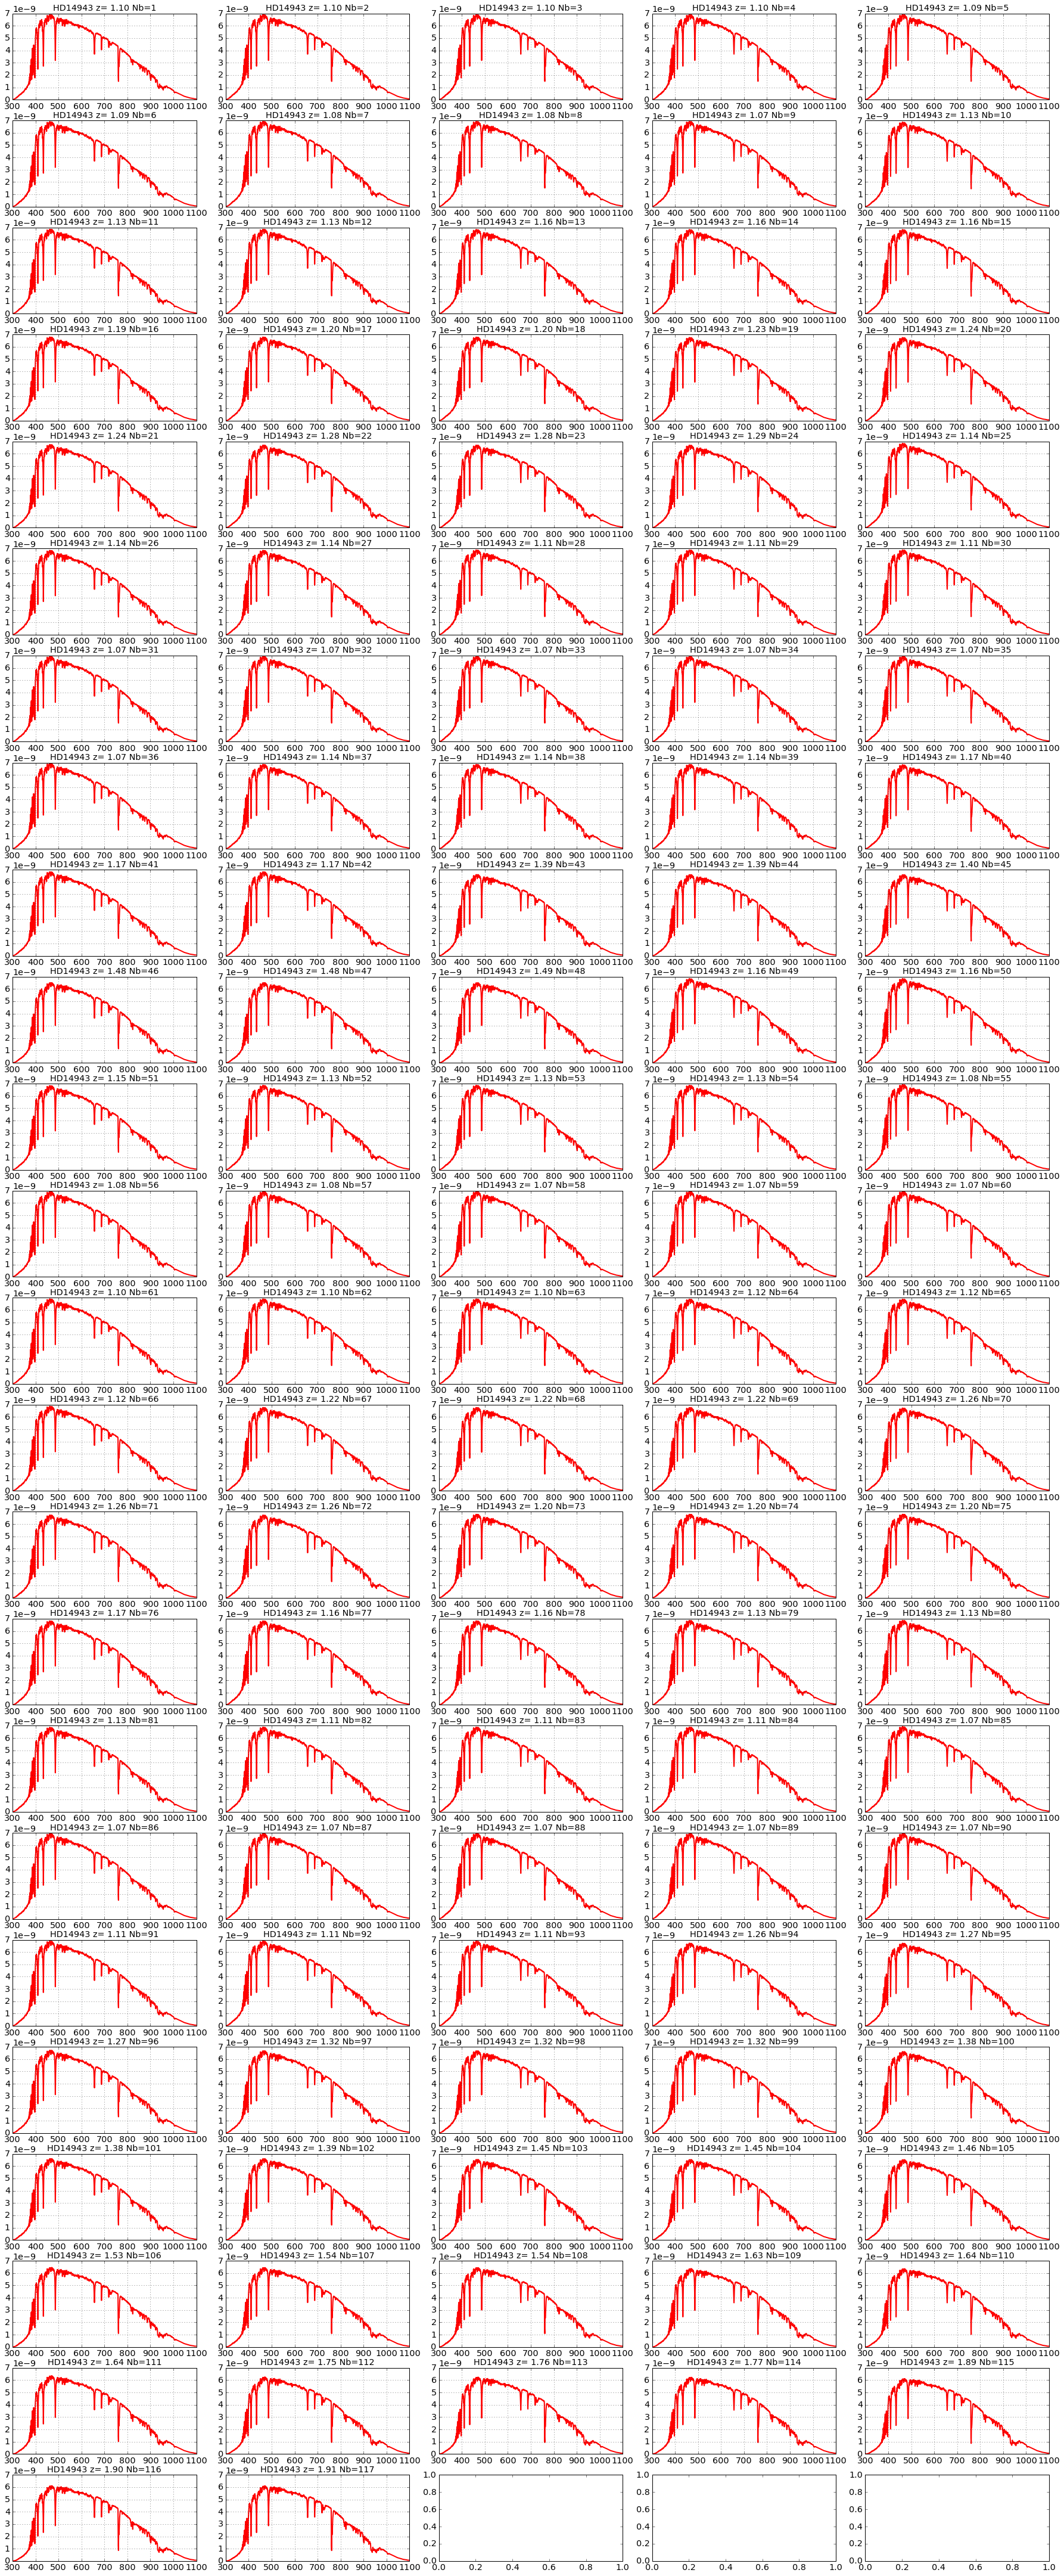

In [59]:
ShowSpectra(all_simwavelength,all_simspectra,all_simtitles,object_name)

### prepare outputfilename

In [ ]:
newfullfilenames=[]
for idx,file in np.ndenumerate(sorted_files):
    short_infilename=file.split("/")[2]
    short_partfilename=re.findall('^finalSpectra__(.*)',short_infilename)
    short_outfilename='fittedSpectra_'+short_partfilename[0]
    newfullfilename=os.path.join(outputdir,short_outfilename)
    newfullfilenames.append(newfullfilename)

In [ ]:
newfullfilenames

### Save outputfilename

In [ ]:
for idx,file in np.ndenumerate(newfullfilenames):
    prihdu = fits.PrimaryHDU(header=all_header[idx[0]],data=spectra_right[idx[0]])
    thdulist = fits.HDUList(prihdu)
    thdulist.writeto(file,clobber=True)

In [ ]:
!ls

In [ ]:
# !ls -l cut_fitsimages